# Load data from Google Drive

In [1]:
!pip install --quiet gdown
!gdown --id 1yDktXuw16oRq0v_TwihBTP9KX6mJ4VhX
!unzip -q /content/Diverse_hand_gesture_dataset.zip

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1yDktXuw16oRq0v_TwihBTP9KX6mJ4VhX
From (redirected): https://drive.google.com/uc?id=1yDktXuw16oRq0v_TwihBTP9KX6mJ4VhX&confirm=t&uuid=617b53d2-b3cf-48ef-bc4e-5033bf5201ec
To: /content/Diverse_hand_gesture_dataset.zip
100% 1.09G/1.09G [00:11<00:00, 95.4MB/s]


In [2]:
class_mapping = {
    0: 'zero',
    1: 'dislike',
    2: 'five',
    3: 'exactly',
    4: 'two',
    5: 'three',
    6: 'left',
    7: 'like' }

In [3]:
train_path = '/content/train'
test_path = '/content/test'

# show simple

txt file :  6 0.647321 0.517857 0.366071 0.357143

class_name:  left
shape of image:  (224, 224, 3)


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

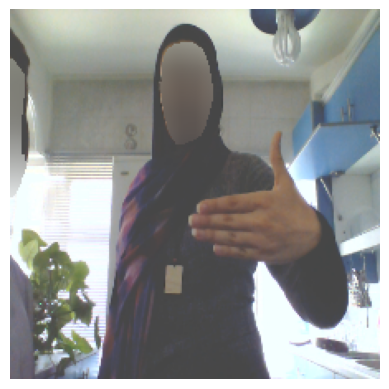

In [7]:
import matplotlib.pyplot as plt
import os

# read text file
c =os.path.join(train_path ,'1479.txt')
txt = open(c).read()
print('txt file : ' ,txt)
print('class_name: ' , class_mapping[int(txt[0])])

# show image
img = plt.imread(os.path.join(train_path , '1479.png'))
print('shape of image: ',img.shape)
plt.imshow(img)
plt.axis('off')


# Preprocessing Data

In [8]:
import random

imagepath=[]
for filename in os.listdir(train_path):
  ext = filename.endswith('.png')
  if ext :
    imagepath.append(filename)

random.shuffle(imagepath)

In [9]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 752.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.0/225.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 2.1 MB/s eta 0:00:00


In [12]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img , img_to_array
import numpy as np


boxes=[]
images=[]
labels=[]

for filename in imagepath :
  text = filename.replace('.png' , '.txt')
  label , startx , starty , endx , endy = open(os.path.join(train_path , text)).read().split(' ')

  img = load_img(os.path.join(train_path , filename) , target_size=(224,224))
  img = img_to_array(img)

  boxes.append([startx , starty , endx , endy])
  images.append(img)
  labels.append(label)

In [13]:
import numpy as np

images = np.array(images, dtype='float32')/255.0
boxes = np.array(boxes, dtype='float32')
labels = np.array(labels, dtype='int32')

# Labels one hot

In [14]:
labels= keras.utils.to_categorical(labels , num_classes= 8)

# Split to train and test

In [15]:
from sklearn.model_selection import train_test_split

split = train_test_split(images , boxes , labels , test_size = 0.2 , random_state = 42)

(imagestrain , imagesval, boxestrain , boxesval, labelstrain , labelsval) = split

# Creat model

In [28]:
from keras.layers import Input
from keras.layers import Dense , Dropout ,  Flatten , GlobalAveragePooling2D
from keras.models import Model
from keras.applications import MobileNetV2

mobilenet = MobileNetV2(weights ='imagenet',include_top=False , input_tensor=Input(shape=(224,224,3)))
mobilenet.trainable = False

gap = GlobalAveragePooling2D()(mobilenet.output)

# boxes
x = Dense(128 , activation = 'relu')(gap)
x = Dense(64 , activation = 'relu')(x)
x = Dense(32 , activation = 'relu')(x)
x = Dense(4 , activation = 'sigmoid' , name = 'box')(x)

# label
y = Dense(512 , activation='relu')(gap)
y = Dropout(0.5)(y)
y = Dense(512 , activation='relu')(y)
y = Dropout(0.5)(y)
y = Dense(8 , activation='softmax' , name = 'class_label')(y)


model = Model(inputs = mobilenet.input , outputs = [x , y])

/tmp/ipython-input-3009664992.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(weights ='imagenet',include_top=False , input_tensor=Input(shape=(224,224,3)))


# Compile

In [29]:
losses ={ 'box' : 'mse',
          'class_label' : 'categorical_crossentropy'
        }

lossweights = {'box' : 1.0,
              'class_label' : 1.0
              }

metrics = {'box' : None,
           'class_label' : 'accuracy'
          }

In [30]:
opt = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss=losses, optimizer=opt, metrics=metrics, loss_weights=lossweights)

# Train

In [32]:
from keras.callbacks import ModelCheckpoint ,EarlyStopping

callback = ModelCheckpoint('hand_gesture.keras',
                           monitor='val_class_label_accuracy',
                           save_best_only=True ,save_weights_only=False,
                           verbose=1)

In [33]:
traintarget = {
    'box' : boxestrain ,
    'class_label' :labelstrain
              }

valtarget = {
    'box' : boxesval ,
    'class_label' : labelsval
            }

In [34]:
H = model.fit(imagestrain , traintarget ,
              validation_data = (imagesval , valtarget) ,
              batch_size=32 ,
              epochs = 10 ,
              callbacks=[callback])

Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - box_loss: 0.0203 - class_label_accuracy: 0.1685 - class_label_loss: 2.2757 - loss: 2.2960
Epoch 1: val_class_label_accuracy improved from -inf to 0.56406, saving model to hand_gesture.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 118s 714ms/step - box_loss: 0.0203 - class_label_accuracy: 0.1689 - class_label_loss: 2.2742 - loss: 2.2945 - val_box_loss: 0.0121 - val_class_label_accuracy: 0.5641 - val_class_label_loss: 1.5291 - val_loss: 1.5412
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - box_loss: 0.0111 - class_label_accuracy: 0.4048 - class_label_loss: 1.6066 - loss: 1.6177
Epoch 2: val_class_label_accuracy improved from 0.56406 to 0.71719, saving model to hand_gesture.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 111s 693ms/step - box_loss: 0.0111 - class_label_accuracy: 0.4050 - class_label_loss: 1.6060 - loss: 1.6171 - val_box_loss: 0.0090 - val_class_label_accuracy: 0.7172 - val_class_label_loss: 1.0735 - val_loss: 1.0825
Epoch 3/10
160/

In [70]:
H = model.fit(imagestrain , traintarget ,
              validation_data = (imagesval , valtarget) ,
              batch_size=32 ,
              epochs = 5 ,
              callbacks=[callback])

Epoch 1/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - box_loss: 0.0027 - class_label_accuracy: 0.8894 - class_label_loss: 0.3348 - loss: 0.3374
Epoch 1: val_class_label_accuracy improved from 0.91328 to 0.92734, saving model to hand_gesture.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 116s 728ms/step - box_loss: 0.0027 - class_label_accuracy: 0.8894 - class_label_loss: 0.3347 - loss: 0.3374 - val_box_loss: 0.0038 - val_class_label_accuracy: 0.9273 - val_class_label_loss: 0.2455 - val_loss: 0.2493
Epoch 2/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - box_loss: 0.0025 - class_label_accuracy: 0.8995 - class_label_loss: 0.2940 - loss: 0.2965
Epoch 2: val_class_label_accuracy improved from 0.92734 to 0.93828, saving model to hand_gesture.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 114s 711ms/step - box_loss: 0.0025 - class_label_accuracy: 0.8996 - class_label_loss: 0.2940 - loss: 0.2965 - val_box_loss: 0.0037 - val_class_label_accuracy: 0.9383 - val_class_label_loss: 0.2287 - val_loss: 0.2324
Epoch 3/5
160/

# Save model

In [53]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [73]:
import shutil

colab_path ='/content/hand_gesture.keras'
drive_path="/content/drive/MyDrive/hand_gesture.keras"

shutil.copy(colab_path, drive_path)
print("Model saved to Google Drive:", drive_path)

Model saved to Google Drive: /content/drive/MyDrive/hand_gesture.keras


# Plot loss and accuracy

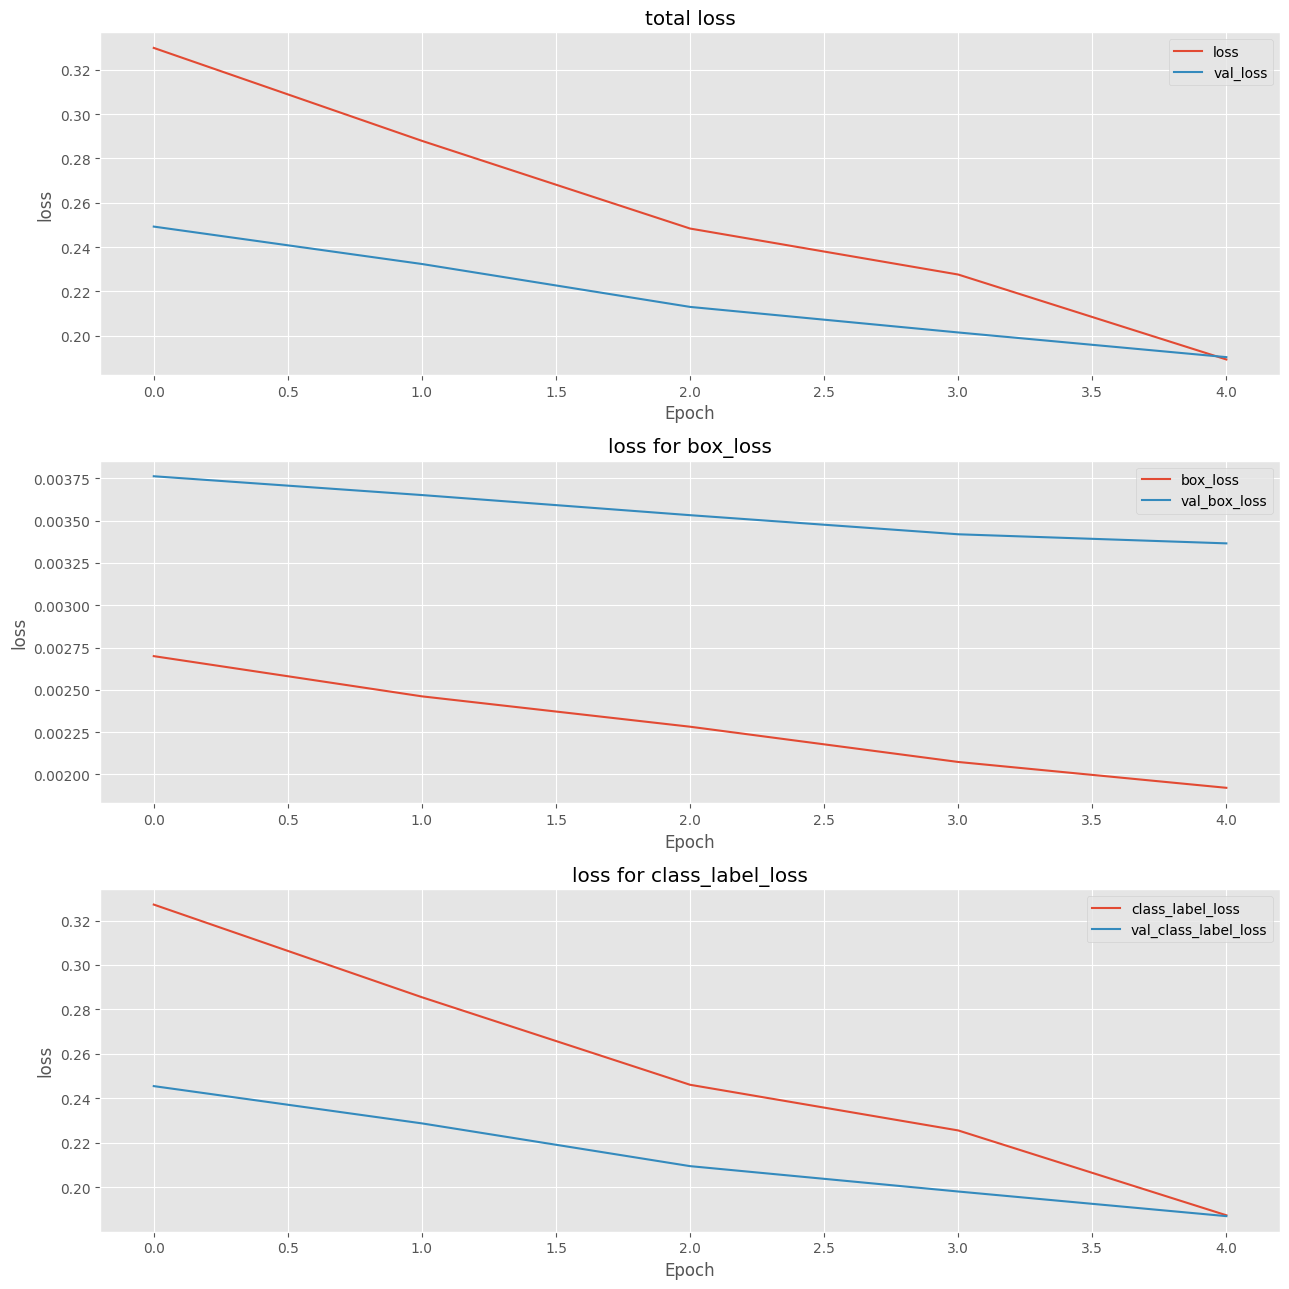

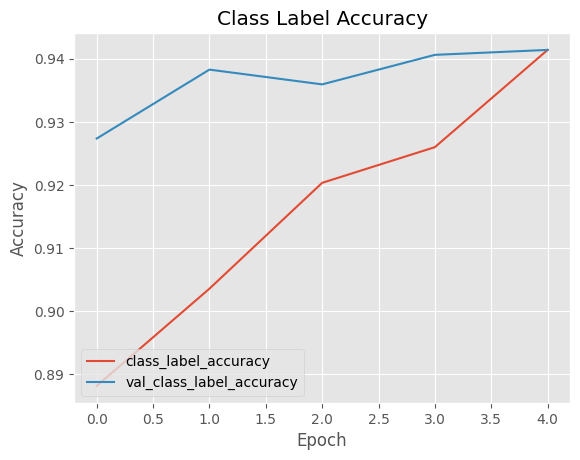

In [76]:
name = ['loss' , 'box_loss' , 'class_label_loss']
n = np.arange(0,H.params['epochs'])
plt.style.use('ggplot')
(fig , ax) = plt.subplots(3,1 , figsize=(13,13))
for (i , l) in enumerate(name):
  title = f'loss for {l}' if l != 'loss' else 'total loss'
  ax[i].set_title(title)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('loss')
  ax[i].plot(n , H.history[l] , label = l)
  ax[i].plot(n , H.history[f'val_{l}'] , label=f'val_{l}')
  ax[i].legend()

plt.tight_layout()

plt.style.use('ggplot')
plt.figure()
plt.plot(n, H.history['class_label_accuracy'] , label= 'class_label_accuracy')
plt.plot(n , H.history['val_class_label_accuracy'] , label= 'val_class_label_accuracy')
plt.title('Class Label Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower left')

# Predict

In [85]:
def inference(imagePath):
    # load the input image (in Keras format) from disk and preprocess
    # it, scaling the pixel intensities to the range [0, 1]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    boxes_pre , label_pre =  model.predict(image)

    class_id = int(np.argmax(label_pre[0]))
    label = class_mapping[class_id]

    img = plt.imread(imagePath)
    image = np.copy(img)
    x, y, w, h = boxes_pre[0]
    H, W = image.shape[:2]
    x, y, w, h = x*W, y*H, w*W, h*H
    x1, y1 = int(x - w/2), int(y - h/2)
    x2, y2 = int(x + w/2), int(y + h/2)

    cv2.rectangle(image, (x1,y1), (x2,y2), (0,255,0), 2)
    cv2.putText(image, label, (x1, max(0,y1-10)), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0,255,0), 2)
    plt.imshow(image)
    plt.axis('off')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


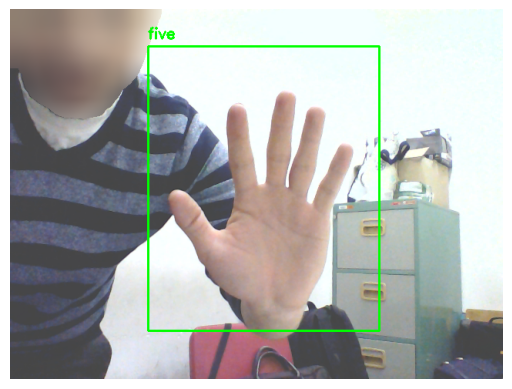

In [86]:
path ='/content/test/five/10088.png'
inference(path)